In [1]:
!pip install ripser gudhi xgboost matplotlib pandas scikit-learn

  Obtaining dependency information for ripser from https://files.pythonhosted.org/packages/0d/9a/3ef5e2c8d5e6add906fdf97a06094307ec052acfa254b1f22f582d7afa1a/ripser-0.6.12-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for gudhi from https://files.pythonhosted.org/packages/b5/46/9790b020b768d5f2a81061e329429d1c5ea143258c4f19792dcdad83dda8/gudhi-3.11.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Cython from https://files.pythonhosted.org/packages/b7/60/415d0f0f7c2e227707baec11c968387d33507d2eb7f26a2950a323c705e5/cython-3.1.3-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for persim from https://files.pythonhosted.org/packages/aa/41/9bd99ddfb4741d6dd2857fda7f6d71f560731f4057e69b98840778d10da1/persim-0.3.8-py3-none-any.whl.metadata
  Obtaining dependency information for deprecated from https://files.pythonhosted.org/packages/6e/c6/ac0b6c1e2d138f1002bcf799d330bd6d85084fece321e662a14223794041/Deprecated-1.2.18-py2.p

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [3]:
!pip install "blosc2~=2.0.0"


  Obtaining dependency information for blosc2~=2.0.0 from https://files.pythonhosted.org/packages/03/d0/685258d475e09d8884d64c8a1eb90a3428fbba782e60b7926f9fdb82c297/blosc2-2.0.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.9 MB 409.6 kB/s eta 0:00:05
   - -------------------------------------- 0.1/1.9 MB 357.2 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/1.9 MB 504.4 kB/s eta 0:00:04
   --- ------------------------------------ 0.2/1.9 MB 615.9 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.9 MB 724.0 kB/s eta 0:00:03
   ----- ---------------------------------- 0.3/1.9 MB 803.7 kB/s eta 0:00:03
   ------- -------------------------------- 0.4/1.9 MB 855.4 kB/s eta 0:00:02
   -------- ----------------------

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ripser import Rips
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

Using numeric column: open  (length=619040)


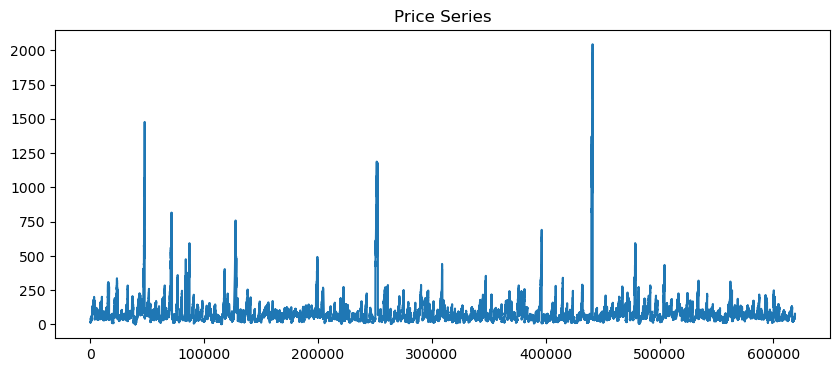

In [5]:
# Example: Load from local CSV (replace filename if needed)
df = pd.read_csv("all_stocks_5yr.csv")

# Pick first numeric column
numeric_cols = df.select_dtypes(include=np.number).columns
if len(numeric_cols) == 0:
    raise ValueError("No numeric column found in CSV!")

prices = df[numeric_cols[0]].interpolate().dropna().values
print(f"Using numeric column: {numeric_cols[0]}  (length={len(prices)})")

plt.figure(figsize=(10,4))
plt.plot(prices)
plt.title("Price Series")
plt.show()

In [6]:
def time_delay_embedding(series, dim=5, tau=1):
    n = len(series) - (dim - 1) * tau
    return np.array([series[i:i + dim * tau:tau] for i in range(n)])


In [7]:
rips = Rips(maxdim=1, verbose=False)

window_size = 200   # number of points per window
step = 50           # stride

features, targets = [], []

for start in range(0, len(prices) - window_size, step):
    window = prices[start:start + window_size]
    embedded = time_delay_embedding(window, dim=5, tau=1)

    try:
        diagrams = rips.fit_transform(embedded)
    except Exception as e:
        print(f"Skipping window {start} due to error: {e}")
        continue

    # Feature extraction (lifetimes)
    f_vec = []
    for pdgm in diagrams:
        if pdgm.shape[1] == 2:
            lifetimes = pdgm[:, 1] - pdgm[:, 0]
            if len(lifetimes) == 0:
                lifetimes = np.array([0])
            f_vec += [lifetimes.sum(), lifetimes.max(), lifetimes.mean()]
    features.append(f_vec)

    # Target: direction of next step after window
    if start + window_size < len(prices) - 1:
        targets.append(int(prices[start + window_size] > prices[start + window_size - 1]))

features = np.array(features)
targets = np.array(targets)

print("Features shape:", features.shape)
print("Targets shape:", targets.shape)
print("Class distribution:", np.unique(targets, return_counts=True))


Features shape: (12377, 6)
Targets shape: (12377,)
Class distribution: (array([0, 1]), array([5849, 6528], dtype=int64))


✅ XGBoost Accuracy: 0.4927302100161551


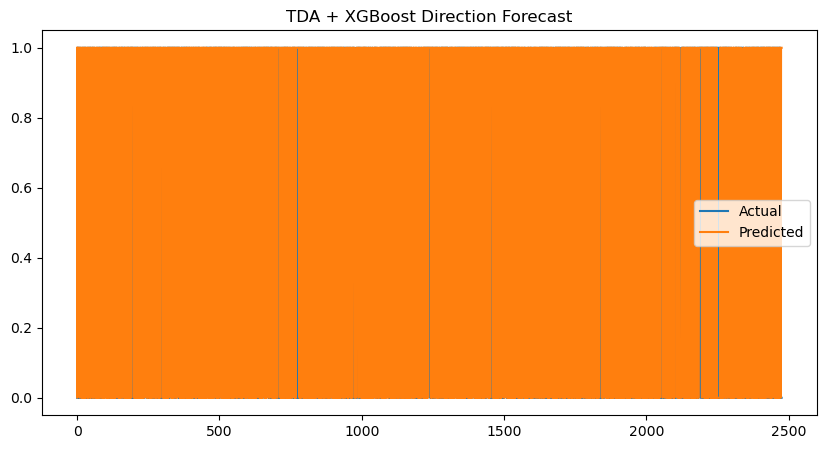

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# ------------------------------
# Step 5.5: Sanitize features
# ------------------------------
features = np.nan_to_num(features, nan=0.0, posinf=1e6, neginf=-1e6)

# ------------------------------
# Step 6: ML model
# ------------------------------
if len(np.unique(targets)) < 2:
    print("⚠️ Not enough class variety in targets. Try longer dataset.")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        features, targets, test_size=0.2, shuffle=False
    )

    model = XGBClassifier(eval_metric="logloss", missing=0.0)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print("✅ XGBoost Accuracy:", acc)

    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.legend()
    plt.title("TDA + XGBoost Direction Forecast")
    plt.show()
